In [33]:
%pip uninstall -y torch torchvision stable-baselines3
%pip install torch==2.0.1 --index-url https://download.pytorch.org/whl/cpu
%pip install gymnasium highway-env stable-baselines3==2.1.0 matplotlib pandas

Found existing installation: torch 2.9.1
Uninstalling torch-2.9.1:
  Successfully uninstalled torch-2.9.1
Found existing installation: stable-baselines3 2.1.0
Uninstalling stable-baselines3-2.1.0:
  Successfully uninstalled stable-baselines3-2.1.0
Note: you may need to restart the kernel to use updated packages.


Looking in indexes: https://download.pytorch.org/whl/cpu
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement torch==2.0.1 (from versions: 2.6.0+cpu, 2.7.0+cpu, 2.7.1+cpu, 2.8.0+cpu, 2.9.0+cpu, 2.9.1+cpu)

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for torch==2.0.1


  Using cached stable_baselines3-2.1.0-py3-none-any.whl.metadata (5.2 kB)
  Using cached torch-2.9.1-cp313-cp313-win_amd64.whl.metadata (30 kB)
Using cached stable_baselines3-2.1.0-py3-none-any.whl (178 kB)
Using cached torch-2.9.1-cp313-cp313-win_amd64.whl (110.9 MB)

   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 [torch]
  


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import gymnasium as gym
import highway_env
from stable_baselines3 import PPO, SAC, DQN
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import CheckpointCallback
import os
import numpy as np
import json
from datetime import datetime
import glob
import pickle

# Disable PyTorch compile to avoid compatibility issues with Python 3.13
import torch
torch._dynamo.config.suppress_errors = True
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

# Ensure environments are available
print("Available highway-env environments:")
highway_envs = [env_id for env_id in gym.envs.registry if 'highway' in env_id.lower() or 'merge' in env_id.lower() or 'roundabout' in env_id.lower() or 'intersection' in env_id.lower()]
print(highway_envs)

Available highway-env environments:
['highway-v0', 'highway-fast-v0', 'intersection-v0', 'intersection-v1', 'intersection-multi-agent-v0', 'intersection-multi-agent-v1', 'merge-v0', 'roundabout-v0']


In [35]:
# Reduced timesteps and number of environments for limited compute
N_ENVS = 1  # Use 1 env to avoid Windows multiprocessing issues in Jupyter
EVAL_EPISODES = 3  # Fewer evaluation episodes

# Timesteps optimized for limited compute while remaining meaningful
NONCURRICULUM_TIMESTEPS = 100_000  # 100k total for non-curriculum
CURRICULUM_STAGE_TIMESTEPS = 25_000  # 25k per stage, 4 stages = 100k total

# Hyperparameters for each algorithm (optimized for faster training)
HYPERS = {
    'PPO': {
        'policy': 'MlpPolicy',
        'policy_kwargs': {'net_arch': [64, 64]},
        'learning_rate': 3e-4,
        'n_steps': 1024,  # Reduced for faster updates
        'batch_size': 64,
        'n_epochs': 10,
        'gamma': 0.99,
        'clip_range': 0.2
    },
    'SAC': {
        'policy': 'MlpPolicy',
        'policy_kwargs': {'net_arch': [128, 128]},  # Reduced network size
        'learning_rate': 3e-4,
        'batch_size': 128,
        'buffer_size': 50_000,  # Smaller buffer for memory efficiency
        'gamma': 0.99
    },
    'DQN': {
        'policy': 'MlpPolicy',
        'policy_kwargs': {'net_arch': [64, 64]},
        'learning_rate': 1e-4,
        'buffer_size': 25_000,  # Smaller buffer
        'batch_size': 32,
        'train_freq': 4
    }
}

In [ ]:
# Function to create a Highway environment
def make_vec_env(map_name, traffic_density, n_envs=1, use_discrete=False, seed=None):
    def create_env():
        env = gym.make(map_name)
        
        # Configure common settings
        env.unwrapped.config["simulation_frequency"] = 15
        env.unwrapped.config["policy_frequency"] = 5
        env.unwrapped.config["duration"] = 40
        env.unwrapped.config["vehicles_count"] = int(50 * traffic_density)
        
        # ALWAYS use DiscreteMetaAction - merge-v0 requires discrete actions
        env.unwrapped.config["action"] = {
            "type": "DiscreteMetaAction",
        }
        
        # Standardize observation space across all maps
        env.unwrapped.config["observation"] = {
            "type": "Kinematics",
            "vehicles_count": 5,
            "features": ["presence", "x", "y", "vx", "vy"],
            "normalize": True,
            "absolute": False,
        }
        
        env.unwrapped.config["offscreen_rendering"] = False
        
        # Map-specific configurations
        if "highway" in map_name:
            env.unwrapped.config["lanes_count"] = 4
            env.unwrapped.config["vehicles_density"] = traffic_density
        elif "merge" in map_name:
            env.unwrapped.config["vehicles_density"] = traffic_density
        elif "roundabout" in map_name:
            env.unwrapped.config["incoming_vehicle_destination"] = None
            env.unwrapped.config["vehicles_density"] = traffic_density
        elif "intersection" in map_name:
            env.unwrapped.config["vehicles_density"] = traffic_density
        
        # Set seed for reproducibility if provided
        if seed is not None:
            env.action_space.seed(seed)
            env.observation_space.seed(seed)
        
        env.reset(seed=seed)
        
        return env
    
    if n_envs == 1:
        return DummyVecEnv([create_env])
    else:
        return SubprocVecEnv([create_env for _ in range(n_envs)])

# Function to create the model for each algorithm
def make_model(algo, env, hyperparams, run_id):
    tensorboard_log = f"./tensorboard_logs/{algo}/{run_id}"
    
    if algo == 'PPO':
        model = PPO(
            hyperparams['policy'], env, verbose=0, tensorboard_log=tensorboard_log,
            policy_kwargs=hyperparams['policy_kwargs'], learning_rate=hyperparams['learning_rate'],
            n_steps=hyperparams['n_steps'], batch_size=hyperparams['batch_size'],
            n_epochs=hyperparams['n_epochs'], gamma=hyperparams['gamma'],
            clip_range=hyperparams['clip_range']
        )
        return model

    if algo == 'SAC':
        model = SAC(
            hyperparams['policy'], env, verbose=0, tensorboard_log=tensorboard_log,
            policy_kwargs=hyperparams['policy_kwargs'], learning_rate=hyperparams['learning_rate'],
            batch_size=hyperparams['batch_size'], buffer_size=hyperparams['buffer_size'],
            gamma=hyperparams['gamma']
        )
        return model

    if algo == 'DQN':
        model = DQN(
            hyperparams['policy'], env, verbose=0, tensorboard_log=tensorboard_log,
            policy_kwargs=hyperparams['policy_kwargs'], learning_rate=hyperparams['learning_rate'],
            buffer_size=hyperparams['buffer_size'], batch_size=hyperparams['batch_size'],
            train_freq=hyperparams['train_freq']
        )
        return model
    
    raise ValueError(f"Unknown algorithm: {algo}")


In [37]:
# Checkpoint and Resume Utilities

def save_replay_buffer(model, path):
    """Save replay buffer for off-policy algorithms (SAC, DQN)"""
    try:
        if hasattr(model, 'replay_buffer') and model.replay_buffer is not None:
            with open(path, 'wb') as f:
                pickle.dump(model.replay_buffer, f)
            print(f"  Replay buffer saved: {path}")
            return True
    except Exception as e:
        print(f"  Warning: Could not save replay buffer: {e}")
    return False

def load_replay_buffer(model, path):
    """Load replay buffer for off-policy algorithms"""
    try:
        if os.path.exists(path):
            with open(path, 'rb') as f:
                model.replay_buffer = pickle.load(f)
            print(f"  Replay buffer loaded: {path}")
            return True
        else:
            print(f"  No replay buffer file found at: {path}")
    except Exception as e:
        print(f"  Warning: Could not load replay buffer: {e}")
    return False

def find_latest_checkpoint(run_dir):
    """Find the most recent checkpoint in a directory"""
    checkpoint_files = glob.glob(os.path.join(run_dir, "*.zip"))
    if not checkpoint_files:
        return None
    # Sort by modification time, return newest
    latest = max(checkpoint_files, key=os.path.getmtime)
    return latest

def create_checkpoint_callback(save_path, save_freq=5000, name_prefix="checkpoint"):
    """Create a callback that saves checkpoints periodically during training"""
    return CheckpointCallback(
        save_freq=save_freq,
        save_path=save_path,
        name_prefix=name_prefix,
        save_replay_buffer=False,  # We handle this separately
        save_vecnormalize=True
    )

In [38]:
# Training function for non-curriculum (trains on ALL maps for fair comparison)
def train_noncurriculum(algo, seed, n_envs=N_ENVS, resume_from=None):
    run_id = datetime.utcnow().strftime("%Y%m%d_%H%M%S")
    base_dir = f"experiments/{algo}/noncurriculum/seed_{seed}"
    out_dir = f"{base_dir}/run_{run_id}"
    
    os.makedirs(out_dir, exist_ok=True)
    
    # Define all map scenarios to train on (matching curriculum)
    training_maps = [
        ("highway-v0", 0.3),
        ("merge-v0", 0.3),
        ("intersection-v0", 0.2),
        ("roundabout-v0", 0.2)
    ]
    
    # Distribute timesteps equally across maps
    timesteps_per_map = NONCURRICULUM_TIMESTEPS // len(training_maps)
    
    print(f"\n{'='*70}")
    print(f"NON-CURRICULUM TRAINING: {algo}")
    print(f"Run ID: {run_id}")
    print(f"Total timesteps: {NONCURRICULUM_TIMESTEPS}")
    print(f"Training on {len(training_maps)} maps equally")
    print(f"Output directory: {out_dir}")
    if resume_from:
        print(f"Resuming from: {resume_from}")
    print(f"{'='*70}\n")

    use_discrete = True  # All algorithms use discrete actions (merge-v0 requires it)
    all_results = {}
    
    # Save run configuration
    run_config = {
        "algo": algo,
        "seed": seed,
        "approach": "non-curriculum",
        "n_envs": n_envs,
        "total_timesteps": NONCURRICULUM_TIMESTEPS,
        "timesteps_per_map": timesteps_per_map,
        "training_maps": training_maps,
        "use_discrete": use_discrete,
        "hyperparams": HYPERS[algo],
        "run_id": run_id,
        "timestamp": datetime.utcnow().isoformat(),
        "resumed_from": resume_from
    }
    
    with open(f"{out_dir}/run_config.json", 'w') as f:
        json.dump(run_config, f, indent=2)
    
    try:
        model = None
        cumulative_timesteps = 0
        start_map_idx = 0
        
        # Resume from checkpoint if provided
        if resume_from and os.path.exists(resume_from):
            print(f"Loading checkpoint: {resume_from}")
            # Load the saved config to determine where we were
            resume_dir = os.path.dirname(resume_from)
            resume_config_path = os.path.join(resume_dir, "run_config.json")
            if os.path.exists(resume_config_path):
                with open(resume_config_path, 'r') as f:
                    resume_config = json.load(f)
                # Try to determine which map to start from based on checkpoint name
                checkpoint_name = os.path.basename(resume_from)
                for idx, (map_name, _) in enumerate(training_maps):
                    if map_name.replace('-', '_') in checkpoint_name:
                        start_map_idx = idx + 1  # Start from next map
                        cumulative_timesteps = timesteps_per_map * (idx + 1)
                        break
            print(f"Resuming from map index {start_map_idx}, cumulative timesteps: {cumulative_timesteps}")
        
        for map_idx, (map_name, traffic) in enumerate(training_maps):
            if map_idx < start_map_idx:
                print(f"Skipping {map_name} (already trained in resumed checkpoint)")
                continue
                
            print(f"\n{'='*60}")
            print(f"Training on Map {map_idx + 1}/{len(training_maps)}: {map_name}")
            print(f"Traffic density: {traffic}")
            print(f"Timesteps for this map: {timesteps_per_map}")
            print(f"{'='*60}")
            
            # Create environment
            env = make_vec_env(map_name, traffic_density=traffic, n_envs=n_envs, 
                              use_discrete=use_discrete, seed=seed + map_idx)
            eval_env = make_vec_env(map_name, traffic_density=traffic, n_envs=1, 
                                   use_discrete=use_discrete, seed=seed + 100 + map_idx)
            
            # Create or update model
            if model is None:
                if resume_from and os.path.exists(resume_from):
                    print("Loading model from checkpoint...")
                    ModelClass = {"PPO": PPO, "SAC": SAC, "DQN": DQN}[algo]
                    model = ModelClass.load(resume_from, env=env)
                    # Try to load replay buffer for off-policy
                    if algo in ("SAC", "DQN"):
                        replay_path = os.path.join(os.path.dirname(resume_from), "replay_buffer.pkl")
                        load_replay_buffer(model, replay_path)
                else:
                    print("Initializing model...")
                    model = make_model(algo, env, HYPERS[algo], run_id)
            else:
                # For subsequent maps, just update the environment (observation space is now standardized)
                print("Updating model environment...")
                model.set_env(env)
            
            # Create checkpoint callback for periodic saves during this map's training
            checkpoint_callback = create_checkpoint_callback(
                save_path=out_dir,
                save_freq=5000,
                name_prefix=f"ckpt_{map_name.replace('-', '_')}"
            )
            
            # Train
            print(f"Training for {timesteps_per_map} timesteps...")
            model.learn(total_timesteps=timesteps_per_map, reset_num_timesteps=False, 
                       callback=checkpoint_callback)
            cumulative_timesteps += timesteps_per_map
            
            # Evaluate on this map
            print(f"Evaluating on {map_name}...")
            mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=EVAL_EPISODES)
            print(f"Results: {mean_reward:.2f} +/- {std_reward:.2f}")
            
            all_results[map_name] = {
                "mean_reward": float(mean_reward),
                "std_reward": float(std_reward),
                "traffic_density": traffic
            }
            
            # Save major checkpoint after each map
            checkpoint_path = f"{out_dir}/checkpoint_{map_name.replace('-', '_')}.zip"
            model.save(checkpoint_path)
            print(f"Checkpoint saved: {checkpoint_path}")
            
            # Save replay buffer for off-policy algorithms
            if algo in ("SAC", "DQN"):
                replay_path = f"{out_dir}/replay_buffer_{map_name.replace('-', '_')}.pkl"
                save_replay_buffer(model, replay_path)
            
            # Close environments to free resources
            try:
                env.close()
            except:
                pass
            try:
                eval_env.close()
            except:
                pass
        
        # Save final model
        final_model_path = f"{out_dir}/final_model.zip"
        model.save(final_model_path)
        print(f"\nFinal model saved: {final_model_path}")
        
        # Save final replay buffer
        if algo in ("SAC", "DQN"):
            final_replay_path = f"{out_dir}/replay_buffer_final.pkl"
            save_replay_buffer(model, final_replay_path)
        
        # Test on all maps with held-out traffic densities
        print(f"\n{'='*60}")
        print("HELD-OUT EVALUATION (Different Traffic Densities)")
        print(f"{'='*60}")
        
        test_maps = [
            ("highway-v0", 0.4),
            ("merge-v0", 0.35),
            ("intersection-v0", 0.25),
            ("roundabout-v0", 0.25)
        ]
        
        test_results = {}
        for map_name, traffic in test_maps:
            print(f"\nTesting on {map_name} (traffic={traffic})...")
            test_env = make_vec_env(map_name, traffic_density=traffic, n_envs=1,
                                   use_discrete=use_discrete, seed=seed + 500)
            mean_reward, std_reward = evaluate_policy(model, test_env, n_eval_episodes=EVAL_EPISODES)
            print(f"  Result: {mean_reward:.2f} +/- {std_reward:.2f}")
            
            test_results[f"{map_name}_holdout"] = {
                "mean_reward": float(mean_reward),
                "std_reward": float(std_reward),
                "traffic_density": traffic
            }
            test_env.close()
        
        # Save all results
        results_summary = {
            "training_results": all_results,
            "test_results": test_results,
            "cumulative_timesteps": cumulative_timesteps
        }
        
        with open(f"{out_dir}/results_summary.json", 'w') as f:
            json.dump(results_summary, f, indent=2)
        
        print(f"\n{'='*60}")
        print("Non-Curriculum Training Complete!")
        print(f"Results saved to: {out_dir}")
        print(f"{'='*60}\n")
        
        return out_dir, results_summary
        
    except Exception as e:
        print(f"\n✗ Error during non-curriculum training: {e}")
        print(f"Checkpoints saved in: {out_dir}")
        print(f"You can resume using: train_noncurriculum('{algo}', {seed}, resume_from='<checkpoint_path>')")
        raise


In [39]:
# Curriculum Training function with progressive map complexity
def train_curriculum(algo, seed, n_envs=N_ENVS, resume_from=None):
    run_id = datetime.utcnow().strftime("%Y%m%d_%H%M%S")
    base_dir = f"experiments/{algo}/curriculum/seed_{seed}"
    out_dir = f"{base_dir}/run_{run_id}"
    
    os.makedirs(out_dir, exist_ok=True)
    
    print(f"\n{'='*70}")
    print(f"CURRICULUM TRAINING: {algo}")
    print(f"Run ID: {run_id}")
    print(f"Output directory: {out_dir}")
    if resume_from:
        print(f"Resuming from: {resume_from}")
    print(f"{'='*70}\n")

    # Define curriculum stages: progressive difficulty across map types and traffic
    # Stage progression: simple highway -> merge -> complex intersection -> roundabout
    stages = [
        ("Stage1_Highway_Low", "highway-v0", 0.2, CURRICULUM_STAGE_TIMESTEPS),
        ("Stage2_Merge_Medium", "merge-v0", 0.3, CURRICULUM_STAGE_TIMESTEPS),
        ("Stage3_Intersection_Medium", "intersection-v0", 0.2, CURRICULUM_STAGE_TIMESTEPS),
        ("Stage4_Roundabout_High", "roundabout-v0", 0.25, CURRICULUM_STAGE_TIMESTEPS),
    ]

    cumulative = 0
    model = None
    use_discrete = True  # All algorithms use discrete actions (merge-v0 requires it)
    stage_results = {}
    start_stage_idx = 0
    
    # Save run configuration
    run_config = {
        "algo": algo,
        "seed": seed,
        "approach": "curriculum",
        "n_envs": n_envs,
        "total_timesteps": sum(s[3] for s in stages),
        "stages": [{"name": s[0], "map": s[1], "traffic": s[2], "timesteps": s[3]} for s in stages],
        "use_discrete": use_discrete,
        "hyperparams": HYPERS[algo],
        "run_id": run_id,
        "timestamp": datetime.utcnow().isoformat(),
        "resumed_from": resume_from
    }
    
    with open(f"{out_dir}/run_config.json", 'w') as f:
        json.dump(run_config, f, indent=2)

    try:
        # Resume from checkpoint if provided
        if resume_from and os.path.exists(resume_from):
            print(f"Loading checkpoint: {resume_from}")
            checkpoint_name = os.path.basename(resume_from)
            # Determine which stage to start from
            for idx, (stage_name, _, _, stage_ts) in enumerate(stages):
                if stage_name in checkpoint_name:
                    start_stage_idx = idx + 1
                    cumulative = stage_ts * (idx + 1)
                    break
            print(f"Resuming from stage index {start_stage_idx}, cumulative timesteps: {cumulative}")
        
        for stage_idx, (stage_name, map_name, traffic_density, stage_timesteps) in enumerate(stages):
            if stage_idx < start_stage_idx:
                print(f"Skipping {stage_name} (already trained in resumed checkpoint)")
                continue
                
            print(f"\n{'='*60}")
            print(f"STAGE {stage_idx + 1}/{len(stages)}: {stage_name}")
            print(f"Map: {map_name}")
            print(f"Traffic density: {traffic_density}")
            print(f"Training timesteps: {stage_timesteps}")
            print(f"{'='*60}")

            # Create environment
            vec_env = make_vec_env(map_name, traffic_density=traffic_density, n_envs=n_envs, 
                                   use_discrete=use_discrete, seed=seed + stage_idx * 10)
            eval_env = make_vec_env(map_name, traffic_density=traffic_density, n_envs=1,
                                   use_discrete=use_discrete, seed=seed + 200 + stage_idx)
            
            # Initialize model if first stage, else update environment
            if model is None:
                if resume_from and os.path.exists(resume_from):
                    print("Loading model from checkpoint...")
                    ModelClass = {"PPO": PPO, "SAC": SAC, "DQN": DQN}[algo]
                    model = ModelClass.load(resume_from, env=vec_env)
                    # Try to load replay buffer for off-policy
                    if algo in ("SAC", "DQN"):
                        replay_path = os.path.join(os.path.dirname(resume_from), "replay_buffer.pkl")
                        load_replay_buffer(model, replay_path)
                else:
                    print("Initializing new model...")
                    model = make_model(algo, vec_env, HYPERS[algo], run_id)
            else:
                # Update environment for next stage (observation space is standardized, so this is safe)
                print("Updating model environment to new stage...")
                model.set_env(vec_env)

            # Create checkpoint callback for periodic saves during this stage
            checkpoint_callback = create_checkpoint_callback(
                save_path=out_dir,
                save_freq=5000,
                name_prefix=f"ckpt_{stage_name}"
            )

            # Train for this stage
            print(f"Training for {stage_timesteps} timesteps...")
            model.learn(total_timesteps=stage_timesteps, reset_num_timesteps=False,
                       callback=checkpoint_callback)
            
            # Evaluate stage performance
            print(f"Evaluating stage performance...")
            mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=EVAL_EPISODES)
            print(f"Stage result: {mean_reward:.2f} +/- {std_reward:.2f}")
            
            stage_results[stage_name] = {
                "map": map_name,
                "traffic_density": traffic_density,
                "mean_reward": float(mean_reward),
                "std_reward": float(std_reward),
                "timesteps": stage_timesteps
            }
            
            # Save major checkpoint after each stage
            checkpoint_path = f"{out_dir}/{stage_name}_model.zip"
            model.save(checkpoint_path)
            print(f"Checkpoint saved: {checkpoint_path}")
            
            # Save replay buffer for off-policy algorithms
            if algo in ("SAC", "DQN"):
                replay_path = f"{out_dir}/replay_buffer_{stage_name}.pkl"
                save_replay_buffer(model, replay_path)

            cumulative += stage_timesteps
            print(f"Cumulative timesteps: {cumulative}")
            
            # Close environments to free resources
            try:
                vec_env.close()
            except:
                pass
            try:
                eval_env.close()
            except:
                pass

        # Final held-out evaluation on all map types with different traffic
        print(f"\n{'='*60}")
        print("HELD-OUT EVALUATION (Unseen Traffic Densities)")
        print(f"{'='*60}")
        
        test_scenarios = [
            ("highway-v0", 0.4),
            ("merge-v0", 0.35),
            ("intersection-v0", 0.25),
            ("roundabout-v0", 0.3)
        ]
        
        test_results = {}
        for map_name, traffic in test_scenarios:
            print(f"\nTesting on {map_name} (traffic={traffic})...")
            held_env = make_vec_env(map_name, traffic_density=traffic, n_envs=1, 
                                   use_discrete=use_discrete, seed=seed + 500)
            
            mean_reward, std_reward = evaluate_policy(model, held_env, n_eval_episodes=EVAL_EPISODES)
            print(f"  Result: {mean_reward:.2f} +/- {std_reward:.2f}")
            
            test_results[f"{map_name}_holdout"] = {
                "mean_reward": float(mean_reward),
                "std_reward": float(std_reward),
                "traffic_density": traffic
            }
            
            held_env.close()
        
        # Save final model
        final_model_path = f"{out_dir}/final_model.zip"
        model.save(final_model_path)
        print(f"\nFinal model saved: {final_model_path}")
        
        # Save final replay buffer
        if algo in ("SAC", "DQN"):
            final_replay_path = f"{out_dir}/replay_buffer_final.pkl"
            save_replay_buffer(model, final_replay_path)
        
        # Save comprehensive results
        results_summary = {
            "stage_results": stage_results,
            "test_results": test_results,
            "cumulative_timesteps": cumulative
        }
        
        with open(f"{out_dir}/results_summary.json", 'w') as f:
            json.dump(results_summary, f, indent=2)
        
        print(f"\n{'='*60}")
        print("Curriculum Training Complete!")
        print(f"Results saved to: {out_dir}")
        print(f"{'='*60}\n")
        
        return out_dir, results_summary
        
    except Exception as e:
        print(f"\n✗ Error during curriculum training: {e}")
        print(f"Checkpoints saved in: {out_dir}")
        print(f"You can resume using: train_curriculum('{algo}', {seed}, resume_from='<checkpoint_path>')")
        raise


In [40]:
def main():
    # Run all three algorithms
    algorithms = ['PPO', 'SAC', 'DQN']
    seed = 0
    
    print(f"\n{'='*70}")
    print(f"REINFORCEMENT LEARNING EXPERIMENT")
    print(f"Running algorithms: {', '.join(algorithms)}")
    print(f"Seed: {seed}")
    print(f"Total timesteps per approach: {NONCURRICULUM_TIMESTEPS}")
    print(f"{'='*70}\n")
    
    all_algorithms_results = {}
    failed_algorithms = []
    
    for algo in algorithms:
        print(f"\n{'#'*70}")
        print(f"{'#'*70}")
        print(f"  ALGORITHM: {algo}")
        print(f"{'#'*70}")
        print(f"{'#'*70}\n")
        
        algo_results = {}
        
        try:
            # Part 1: Non-Curriculum Training (trains on all maps equally)
            print(f"\n{'='*70}")
            print(f"PART 1: {algo} - NON-CURRICULUM APPROACH")
            print(f"{'='*70}")
            out_dir_nc, results_nc = train_noncurriculum(algo, seed=seed)
            algo_results['non_curriculum'] = {
                'directory': out_dir_nc,
                'results': results_nc
            }
            
            print(f"\n✓ {algo} Non-curriculum training completed!")
            print(f"  Training results:")
            for map_name, metrics in results_nc['training_results'].items():
                print(f"    {map_name}: {metrics['mean_reward']:.2f} ± {metrics['std_reward']:.2f}")
            
            # Part 2: Curriculum Training (progressive difficulty)
            print(f"\n{'='*70}")
            print(f"PART 2: {algo} - CURRICULUM APPROACH")
            print(f"{'='*70}")
            out_dir_curr, results_curr = train_curriculum(algo, seed=seed)
            algo_results['curriculum'] = {
                'directory': out_dir_curr,
                'results': results_curr
            }
            
            print(f"\n✓ {algo} Curriculum training completed!")
            print(f"  Stage results:")
            for stage_name, metrics in results_curr['stage_results'].items():
                print(f"    {stage_name}: {metrics['mean_reward']:.2f} ± {metrics['std_reward']:.2f}")
            
            # Algorithm Comparison
            print(f"\n{'='*70}")
            print(f"{algo} COMPARISON - HELD-OUT TEST PERFORMANCE")
            print(f"{'='*70}")
            
            print(f"\n{algo} Non-Curriculum Test Results:")
            for map_name, metrics in results_nc['test_results'].items():
                print(f"  {map_name}: {metrics['mean_reward']:.2f} ± {metrics['std_reward']:.2f}")
            
            print(f"\n{algo} Curriculum Test Results:")
            for map_name, metrics in results_curr['test_results'].items():
                print(f"  {map_name}: {metrics['mean_reward']:.2f} ± {metrics['std_reward']:.2f}")
            
            # Calculate average performance
            nc_avg = np.mean([m['mean_reward'] for m in results_nc['test_results'].values()])
            curr_avg = np.mean([m['mean_reward'] for m in results_curr['test_results'].values()])
            
            print(f"\n{'='*70}")
            print(f"{algo} SUMMARY")
            print(f"{'='*70}")
            print(f"Non-Curriculum Average Test Score:  {nc_avg:.2f}")
            print(f"Curriculum Average Test Score:      {curr_avg:.2f}")
            print(f"Difference (Curriculum - Non-Curr): {curr_avg - nc_avg:+.2f}")
            
            if curr_avg > nc_avg:
                print(f"\n✓ {algo} Curriculum learning shows {((curr_avg - nc_avg) / abs(nc_avg) * 100):.1f}% improvement!")
            else:
                print(f"\n→ {algo} Non-curriculum approach performs {((nc_avg - curr_avg) / abs(curr_avg) * 100):.1f}% better.")
            
            # Save algorithm-specific comparison
            comparison_file = f"experiments/{algo}/comparison_seed_{seed}_{datetime.utcnow().strftime('%Y%m%d_%H%M%S')}.json"
            os.makedirs(os.path.dirname(comparison_file), exist_ok=True)
            with open(comparison_file, 'w') as f:
                json.dump(algo_results, f, indent=2)
            print(f"\n{algo} comparison saved to: {comparison_file}")
            
            all_algorithms_results[algo] = algo_results
            
        except Exception as e:
            print(f"\n✗ {algo} training failed with error: {e}")
            import traceback
            traceback.print_exc()
            print(f"\nContinuing with next algorithm...")
            failed_algorithms.append(algo)
            continue
    
    # Final cross-algorithm comparison
    print(f"\n{'#'*70}")
    print(f"{'#'*70}")
    print(f"  FINAL CROSS-ALGORITHM COMPARISON")
    print(f"{'#'*70}")
    print(f"{'#'*70}\n")
    
    comparison_table = []
    for algo in algorithms:
        if algo in all_algorithms_results:
            nc_res = all_algorithms_results[algo]['non_curriculum']['results']['test_results']
            curr_res = all_algorithms_results[algo]['curriculum']['results']['test_results']
            
            nc_avg = np.mean([m['mean_reward'] for m in nc_res.values()])
            curr_avg = np.mean([m['mean_reward'] for m in curr_res.values()])
            
            comparison_table.append({
                'algorithm': algo,
                'non_curriculum_avg': nc_avg,
                'curriculum_avg': curr_avg,
                'difference': curr_avg - nc_avg,
                'improvement_pct': ((curr_avg - nc_avg) / abs(nc_avg) * 100) if nc_avg != 0 else 0
            })
    
    print(f"{'Algorithm':<12} {'Non-Curr':<12} {'Curriculum':<12} {'Difference':<12} {'Improvement'}")
    print("="*70)
    for row in comparison_table:
        print(f"{row['algorithm']:<12} {row['non_curriculum_avg']:<12.2f} {row['curriculum_avg']:<12.2f} "
              f"{row['difference']:<+12.2f} {row['improvement_pct']:>+.1f}%")
    
    # Save overall comparison
    overall_comparison_file = f"experiments/all_algorithms_comparison_seed_{seed}_{datetime.utcnow().strftime('%Y%m%d_%H%M%S')}.json"
    os.makedirs("experiments", exist_ok=True)
    with open(overall_comparison_file, 'w') as f:
        json.dump({
            'algorithms': all_algorithms_results,
            'summary_table': comparison_table
        }, f, indent=2)
    
    print(f"\n{'='*70}")
    if all_algorithms_results:
        print(f"Overall comparison saved to: {overall_comparison_file}")
    print(f"{'='*70}\n")
    
    # Report final status
    if failed_algorithms:
        print(f"\n⚠ EXPERIMENTS COMPLETED WITH ERRORS")
        print(f"Failed algorithms: {', '.join(failed_algorithms)}")
        print(f"Successful algorithms: {', '.join([a for a in algorithms if a not in failed_algorithms])}")
        if not all_algorithms_results:
            print(f"\n✗ ALL ALGORITHMS FAILED - NO RESULTS GENERATED\n")
            return
    else:
        print("\n✓ ALL EXPERIMENTS COMPLETED SUCCESSFULLY!\n")

if __name__ == "__main__":
    main()


REINFORCEMENT LEARNING EXPERIMENT
Running algorithms: PPO, SAC, DQN
Seed: 0
Total timesteps per approach: 100000


######################################################################
######################################################################
  ALGORITHM: PPO
######################################################################
######################################################################


PART 1: PPO - NON-CURRICULUM APPROACH

NON-CURRICULUM TRAINING: PPO
Run ID: 20251123_005631
Total timesteps: 100000
Training on 4 maps equally
Output directory: experiments/PPO/noncurriculum/seed_0/run_20251123_005631


Training on Map 1/4: highway-v0
Traffic density: 0.3
Timesteps for this map: 25000
Initializing model...
Training for 25000 timesteps...


C:\Users\saimb\AppData\Local\Temp\ipykernel_26464\1652287602.py:3: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  run_id = datetime.utcnow().strftime("%Y%m%d_%H%M%S")
C:\Users\saimb\AppData\Local\Temp\ipykernel_26464\1652287602.py:45: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat(),


Evaluating on highway-v0...


c:\Users\saimb\AppData\Local\Programs\Python\Python313\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Results: 173.61 +/- 11.24
Checkpoint saved: experiments/PPO/noncurriculum/seed_0/run_20251123_005631/checkpoint_highway_v0.zip

Training on Map 2/4: merge-v0
Traffic density: 0.3
Timesteps for this map: 25000
Updating model environment...
Training for 25000 timesteps...
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
over

c:\Users\saimb\AppData\Local\Programs\Python\Python313\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

c:\Users\saimb\AppData\Local\Programs\Python\Python313\Lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment intersection-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(
c:\Users\saimb\AppData\Local\Programs\Python\Python313\Lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment intersection-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


Updating model environment...
Training for 25000 timesteps...
Evaluating on intersection-v0...
Evaluating on intersection-v0...


c:\Users\saimb\AppData\Local\Programs\Python\Python313\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Results: 18.33 +/- 6.65
Checkpoint saved: experiments/PPO/noncurriculum/seed_0/run_20251123_005631/checkpoint_intersection_v0.zip

Training on Map 4/4: roundabout-v0
Traffic density: 0.2
Timesteps for this map: 25000
Updating model environment...
Training for 25000 timesteps...
Evaluating on roundabout-v0...
Evaluating on roundabout-v0...


c:\Users\saimb\AppData\Local\Programs\Python\Python313\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Results: 33.33 +/- 20.22
Checkpoint saved: experiments/PPO/noncurriculum/seed_0/run_20251123_005631/checkpoint_roundabout_v0.zip

Final model saved: experiments/PPO/noncurriculum/seed_0/run_20251123_005631/final_model.zip

HELD-OUT EVALUATION (Different Traffic Densities)

Testing on highway-v0 (traffic=0.4)...


c:\Users\saimb\AppData\Local\Programs\Python\Python313\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


  Result: 139.82 +/- 47.27

Testing on merge-v0 (traffic=0.35)...
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse


c:\Users\saimb\AppData\Local\Programs\Python\Python313\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

c:\Users\saimb\AppData\Local\Programs\Python\Python313\Lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment intersection-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(
c:\Users\saimb\AppData\Local\Programs\Python\Python313\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


  Result: 18.33 +/- 5.19

Testing on roundabout-v0 (traffic=0.25)...


c:\Users\saimb\AppData\Local\Programs\Python\Python313\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


  Result: 37.56 +/- 15.33

Non-Curriculum Training Complete!
Results saved to: experiments/PPO/noncurriculum/seed_0/run_20251123_005631


✓ PPO Non-curriculum training completed!
  Training results:
    highway-v0: 173.61 ± 11.24
    merge-v0: 70.49 ± 5.38
    intersection-v0: 18.33 ± 6.65
    roundabout-v0: 33.33 ± 20.22

PART 2: PPO - CURRICULUM APPROACH

CURRICULUM TRAINING: PPO
Run ID: 20251123_011735
Output directory: experiments/PPO/curriculum/seed_0/run_20251123_011735


STAGE 1/4: Stage1_Highway_Low
Map: highway-v0
Traffic density: 0.2
Training timesteps: 25000
Initializing new model...
Training for 25000 timesteps...


C:\Users\saimb\AppData\Local\Temp\ipykernel_26464\1934574298.py:3: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  run_id = datetime.utcnow().strftime("%Y%m%d_%H%M%S")
C:\Users\saimb\AppData\Local\Temp\ipykernel_26464\1934574298.py:43: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat(),


Evaluating stage performance...


c:\Users\saimb\AppData\Local\Programs\Python\Python313\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Stage result: 173.23 +/- 0.07
Checkpoint saved: experiments/PPO/curriculum/seed_0/run_20251123_011735/Stage1_Highway_Low_model.zip
Cumulative timesteps: 25000

STAGE 2/4: Stage2_Merge_Medium
Map: merge-v0
Traffic density: 0.3
Training timesteps: 25000
Updating model environment to new stage...
Training for 25000 timesteps...
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
c

c:\Users\saimb\AppData\Local\Programs\Python\Python313\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

c:\Users\saimb\AppData\Local\Programs\Python\Python313\Lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment intersection-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(
c:\Users\saimb\AppData\Local\Programs\Python\Python313\Lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment intersection-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


Updating model environment to new stage...
Training for 25000 timesteps...
Evaluating stage performance...
Evaluating stage performance...


c:\Users\saimb\AppData\Local\Programs\Python\Python313\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Stage result: 20.33 +/- 3.86
Checkpoint saved: experiments/PPO/curriculum/seed_0/run_20251123_011735/Stage3_Intersection_Medium_model.zip
Cumulative timesteps: 75000

STAGE 4/4: Stage4_Roundabout_High
Map: roundabout-v0
Traffic density: 0.25
Training timesteps: 25000
Updating model environment to new stage...
Training for 25000 timesteps...
Evaluating stage performance...
Evaluating stage performance...


c:\Users\saimb\AppData\Local\Programs\Python\Python313\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Stage result: 14.17 +/- 6.85
Checkpoint saved: experiments/PPO/curriculum/seed_0/run_20251123_011735/Stage4_Roundabout_High_model.zip
Cumulative timesteps: 100000

HELD-OUT EVALUATION (Unseen Traffic Densities)

Testing on highway-v0 (traffic=0.4)...


c:\Users\saimb\AppData\Local\Programs\Python\Python313\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


  Result: 118.92 +/- 32.50

Testing on merge-v0 (traffic=0.35)...
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse


c:\Users\saimb\AppData\Local\Programs\Python\Python313\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

c:\Users\saimb\AppData\Local\Programs\Python\Python313\Lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment intersection-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(
c:\Users\saimb\AppData\Local\Programs\Python\Python313\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


  Result: 18.33 +/- 5.19

Testing on roundabout-v0 (traffic=0.3)...


c:\Users\saimb\AppData\Local\Programs\Python\Python313\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


  Result: 37.08 +/- 14.90

Final model saved: experiments/PPO/curriculum/seed_0/run_20251123_011735/final_model.zip

Curriculum Training Complete!
Results saved to: experiments/PPO/curriculum/seed_0/run_20251123_011735


✓ PPO Curriculum training completed!
  Stage results:
    Stage1_Highway_Low: 173.23 ± 0.07
    Stage2_Merge_Medium: 68.75 ± 5.04
    Stage3_Intersection_Medium: 20.33 ± 3.86
    Stage4_Roundabout_High: 14.17 ± 6.85

PPO COMPARISON - HELD-OUT TEST PERFORMANCE

PPO Non-Curriculum Test Results:
  highway-v0_holdout: 139.82 ± 47.27
  merge-v0_holdout: 45.66 ± 19.10
  intersection-v0_holdout: 18.33 ± 5.19
  roundabout-v0_holdout: 37.56 ± 15.33

PPO Curriculum Test Results:
  highway-v0_holdout: 118.92 ± 32.50
  merge-v0_holdout: 73.53 ± 0.16
  intersection-v0_holdout: 18.33 ± 5.19
  roundabout-v0_holdout: 37.08 ± 14.90

PPO SUMMARY
Non-Curriculum Average Test Score:  60.34
Curriculum Average Test Score:      61.97
Difference (Curriculum - Non-Curr): +1.63

✓ PPO Curriculum

C:\Users\saimb\AppData\Local\Temp\ipykernel_26464\36359090.py:86: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  comparison_file = f"experiments/{algo}/comparison_seed_{seed}_{datetime.utcnow().strftime('%Y%m%d_%H%M%S')}.json"
C:\Users\saimb\AppData\Local\Temp\ipykernel_26464\1652287602.py:3: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  run_id = datetime.utcnow().strftime("%Y%m%d_%H%M%S")
C:\Users\saimb\AppData\Local\Temp\ipykernel_26464\1652287602.py:45: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": date

Evaluating on highway-v0...


c:\Users\saimb\AppData\Local\Programs\Python\Python313\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Results: 155.38 +/- 4.42
Checkpoint saved: experiments/DQN/noncurriculum/seed_0/run_20251123_013716/checkpoint_highway_v0.zip
  Replay buffer saved: experiments/DQN/noncurriculum/seed_0/run_20251123_013716/replay_buffer_highway_v0.pkl

Training on Map 2/4: merge-v0
Traffic density: 0.3
Timesteps for this map: 25000
Updating model environment...
Training for 25000 timesteps...
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

c:\Users\saimb\AppData\Local\Programs\Python\Python313\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

c:\Users\saimb\AppData\Local\Programs\Python\Python313\Lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment intersection-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(
c:\Users\saimb\AppData\Local\Programs\Python\Python313\Lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment intersection-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


Updating model environment...
Training for 25000 timesteps...
Evaluating on intersection-v0...
Evaluating on intersection-v0...


c:\Users\saimb\AppData\Local\Programs\Python\Python313\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Results: 18.33 +/- 6.65
Checkpoint saved: experiments/DQN/noncurriculum/seed_0/run_20251123_013716/checkpoint_intersection_v0.zip
  Replay buffer saved: experiments/DQN/noncurriculum/seed_0/run_20251123_013716/replay_buffer_intersection_v0.pkl

Training on Map 4/4: roundabout-v0
Traffic density: 0.2
Timesteps for this map: 25000
Updating model environment...
Training for 25000 timesteps...
Evaluating on roundabout-v0...
Evaluating on roundabout-v0...


c:\Users\saimb\AppData\Local\Programs\Python\Python313\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Results: 11.94 +/- 3.22
Checkpoint saved: experiments/DQN/noncurriculum/seed_0/run_20251123_013716/checkpoint_roundabout_v0.zip
  Replay buffer saved: experiments/DQN/noncurriculum/seed_0/run_20251123_013716/replay_buffer_roundabout_v0.pkl

Final model saved: experiments/DQN/noncurriculum/seed_0/run_20251123_013716/final_model.zip
  Replay buffer saved: experiments/DQN/noncurriculum/seed_0/run_20251123_013716/replay_buffer_final.pkl

HELD-OUT EVALUATION (Different Traffic Densities)

Testing on highway-v0 (traffic=0.4)...


c:\Users\saimb\AppData\Local\Programs\Python\Python313\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


  Result: 126.25 +/- 58.72

Testing on merge-v0 (traffic=0.35)...
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse


c:\Users\saimb\AppData\Local\Programs\Python\Python313\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overF

c:\Users\saimb\AppData\Local\Programs\Python\Python313\Lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment intersection-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(
c:\Users\saimb\AppData\Local\Programs\Python\Python313\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


  Result: 8.67 +/- 6.02

Testing on roundabout-v0 (traffic=0.25)...


c:\Users\saimb\AppData\Local\Programs\Python\Python313\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


  Result: 30.47 +/- 15.42

Non-Curriculum Training Complete!
Results saved to: experiments/DQN/noncurriculum/seed_0/run_20251123_013716


✓ DQN Non-curriculum training completed!
  Training results:
    highway-v0: 155.38 ± 4.42
    merge-v0: 63.66 ± 5.25
    intersection-v0: 18.33 ± 6.65
    roundabout-v0: 11.94 ± 3.22

PART 2: DQN - CURRICULUM APPROACH

CURRICULUM TRAINING: DQN
Run ID: 20251123_020409
Output directory: experiments/DQN/curriculum/seed_0/run_20251123_020409


STAGE 1/4: Stage1_Highway_Low
Map: highway-v0
Traffic density: 0.2
Training timesteps: 25000
Initializing new model...
Training for 25000 timesteps...


C:\Users\saimb\AppData\Local\Temp\ipykernel_26464\1934574298.py:3: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  run_id = datetime.utcnow().strftime("%Y%m%d_%H%M%S")
C:\Users\saimb\AppData\Local\Temp\ipykernel_26464\1934574298.py:43: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat(),


Evaluating stage performance...


c:\Users\saimb\AppData\Local\Programs\Python\Python313\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Stage result: 141.06 +/- 4.19
Checkpoint saved: experiments/DQN/curriculum/seed_0/run_20251123_020409/Stage1_Highway_Low_model.zip
  Replay buffer saved: experiments/DQN/curriculum/seed_0/run_20251123_020409/replay_buffer_Stage1_Highway_Low.pkl
Cumulative timesteps: 25000

STAGE 2/4: Stage2_Merge_Medium
Map: merge-v0
Traffic density: 0.3
Training timesteps: 25000
Updating model environment to new stage...
Training for 25000 timesteps...
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

c:\Users\saimb\AppData\Local\Programs\Python\Python313\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

c:\Users\saimb\AppData\Local\Programs\Python\Python313\Lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment intersection-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(
c:\Users\saimb\AppData\Local\Programs\Python\Python313\Lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment intersection-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


Updating model environment to new stage...
Training for 25000 timesteps...
Evaluating stage performance...
Evaluating stage performance...


c:\Users\saimb\AppData\Local\Programs\Python\Python313\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Stage result: 20.33 +/- 3.86
Checkpoint saved: experiments/DQN/curriculum/seed_0/run_20251123_020409/Stage3_Intersection_Medium_model.zip
  Replay buffer saved: experiments/DQN/curriculum/seed_0/run_20251123_020409/replay_buffer_Stage3_Intersection_Medium.pkl
Cumulative timesteps: 75000

STAGE 4/4: Stage4_Roundabout_High
Map: roundabout-v0
Traffic density: 0.25
Training timesteps: 25000
Updating model environment to new stage...
Training for 25000 timesteps...
Evaluating stage performance...
Evaluating stage performance...


c:\Users\saimb\AppData\Local\Programs\Python\Python313\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Stage result: 46.86 +/- 0.43
Checkpoint saved: experiments/DQN/curriculum/seed_0/run_20251123_020409/Stage4_Roundabout_High_model.zip
  Replay buffer saved: experiments/DQN/curriculum/seed_0/run_20251123_020409/replay_buffer_Stage4_Roundabout_High.pkl
Cumulative timesteps: 100000

HELD-OUT EVALUATION (Unseen Traffic Densities)

Testing on highway-v0 (traffic=0.4)...


c:\Users\saimb\AppData\Local\Programs\Python\Python313\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


  Result: 179.91 +/- 12.57

Testing on merge-v0 (traffic=0.35)...
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse


c:\Users\saimb\AppData\Local\Programs\Python\Python313\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overF

c:\Users\saimb\AppData\Local\Programs\Python\Python313\Lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment intersection-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(
c:\Users\saimb\AppData\Local\Programs\Python\Python313\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


  Result: 13.67 +/- 5.44

Testing on roundabout-v0 (traffic=0.3)...


c:\Users\saimb\AppData\Local\Programs\Python\Python313\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


  Result: 32.92 +/- 17.23

Final model saved: experiments/DQN/curriculum/seed_0/run_20251123_020409/final_model.zip
  Replay buffer saved: experiments/DQN/curriculum/seed_0/run_20251123_020409/replay_buffer_final.pkl

Curriculum Training Complete!
Results saved to: experiments/DQN/curriculum/seed_0/run_20251123_020409


✓ DQN Curriculum training completed!
  Stage results:
    Stage1_Highway_Low: 141.06 ± 4.19
    Stage2_Merge_Medium: 70.13 ± 4.90
    Stage3_Intersection_Medium: 20.33 ± 3.86
    Stage4_Roundabout_High: 46.86 ± 0.43

DQN COMPARISON - HELD-OUT TEST PERFORMANCE

DQN Non-Curriculum Test Results:
  highway-v0_holdout: 126.25 ± 58.72
  merge-v0_holdout: 29.24 ± 5.75
  intersection-v0_holdout: 8.67 ± 6.02
  roundabout-v0_holdout: 30.47 ± 15.42

DQN Curriculum Test Results:
  highway-v0_holdout: 179.91 ± 12.57
  merge-v0_holdout: 29.24 ± 5.75
  intersection-v0_holdout: 13.67 ± 5.44
  roundabout-v0_holdout: 32.92 ± 17.23

DQN SUMMARY
Non-Curriculum Average Test Score:  48.66
Cu

C:\Users\saimb\AppData\Local\Temp\ipykernel_26464\36359090.py:86: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  comparison_file = f"experiments/{algo}/comparison_seed_{seed}_{datetime.utcnow().strftime('%Y%m%d_%H%M%S')}.json"
C:\Users\saimb\AppData\Local\Temp\ipykernel_26464\36359090.py:133: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  overall_comparison_file = f"experiments/all_algorithms_comparison_seed_{seed}_{datetime.utcnow().strftime('%Y%m%d_%H%M%S')}.json"


## Resume Training from Checkpoint

**Use this section if your training was interrupted and you need to resume.**

### How to Resume:

1. **Find your checkpoint:** Check the `experiments/` folder for your algorithm's run directory
2. **Run the resume function below** with the appropriate parameters
3. The code will automatically skip completed work and continue from where it stopped

### Resume Options:

**Option A: Auto-resume (finds latest checkpoint automatically)**
```python
resume_training('PPO', seed=0, approach='curriculum')
```

**Option B: Resume from specific checkpoint**
```python
resume_training('PPO', seed=0, approach='noncurriculum', 
                checkpoint_path='experiments/PPO/noncurriculum/seed_0/run_20251123_143022/checkpoint_merge_v0.zip')
```

### Resume Multiple Algorithms:

If multiple algorithms were interrupted, resume them one at a time:
```python
for algo in ['PPO', 'SAC', 'DQN']:
    print(f"\nResuming {algo}...")
    try:
        # Resume non-curriculum
        resume_training(algo, seed=0, approach='noncurriculum')
        # Resume curriculum
        resume_training(algo, seed=0, approach='curriculum')
    except Exception as e:
        print(f"Could not resume {algo}: {e}")
```

**Run the cell below after uncommenting the appropriate resume command.**

In [41]:
# RESUME TRAINING - Use this if training was interrupted

def resume_training(algo, seed, approach='curriculum', checkpoint_path=None):
    """
    Resume training from a checkpoint.
    
    Args:
        algo: Algorithm name ('PPO', 'SAC', 'DQN')
        seed: Random seed used in original run
        approach: 'curriculum' or 'noncurriculum'
        checkpoint_path: Path to checkpoint file, or None to auto-find latest
    """
    if checkpoint_path is None:
        # Auto-find latest checkpoint
        base_dir = f"experiments/{algo}/{approach}/seed_{seed}"
        if not os.path.exists(base_dir):
            print(f"No runs found in {base_dir}")
            return
        
        # Find most recent run directory
        run_dirs = glob.glob(os.path.join(base_dir, "run_*"))
        if not run_dirs:
            print(f"No run directories found in {base_dir}")
            return
        
        latest_run = max(run_dirs, key=os.path.getmtime)
        checkpoint_path = find_latest_checkpoint(latest_run)
        
        if checkpoint_path is None:
            print(f"No checkpoint files found in {latest_run}")
            return
    
    print(f"Resuming {approach} training for {algo}")
    print(f"Using checkpoint: {checkpoint_path}")
    
    if approach == 'curriculum':
        return train_curriculum(algo, seed, resume_from=checkpoint_path)
    else:
        return train_noncurriculum(algo, seed, resume_from=checkpoint_path)

# Example usage (uncomment and modify as needed):
# resume_training('PPO', seed=0, approach='curriculum')
# Or specify exact checkpoint:
# resume_training('PPO', seed=0, approach='curriculum', 
#                checkpoint_path='experiments/PPO/curriculum/seed_0/run_20231123_120000/Stage2_Merge_Medium_model.zip')

In [43]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



GENERATING VISUALIZATIONS

Loading experiment results...
✓ Data loaded for: PPO, DQN

Generating plots...

✓ Saved: plots/training_performance.png
✓ Saved: plots/training_performance.png


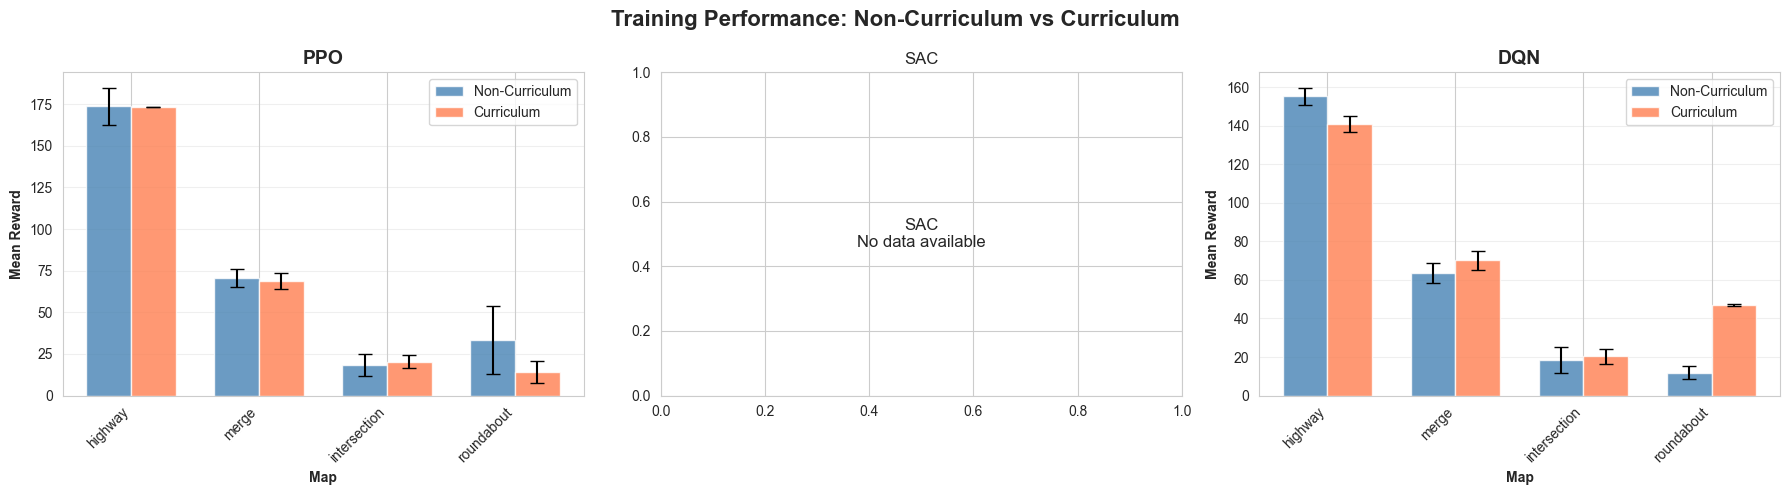

✓ Saved: plots/holdout_comparison.png


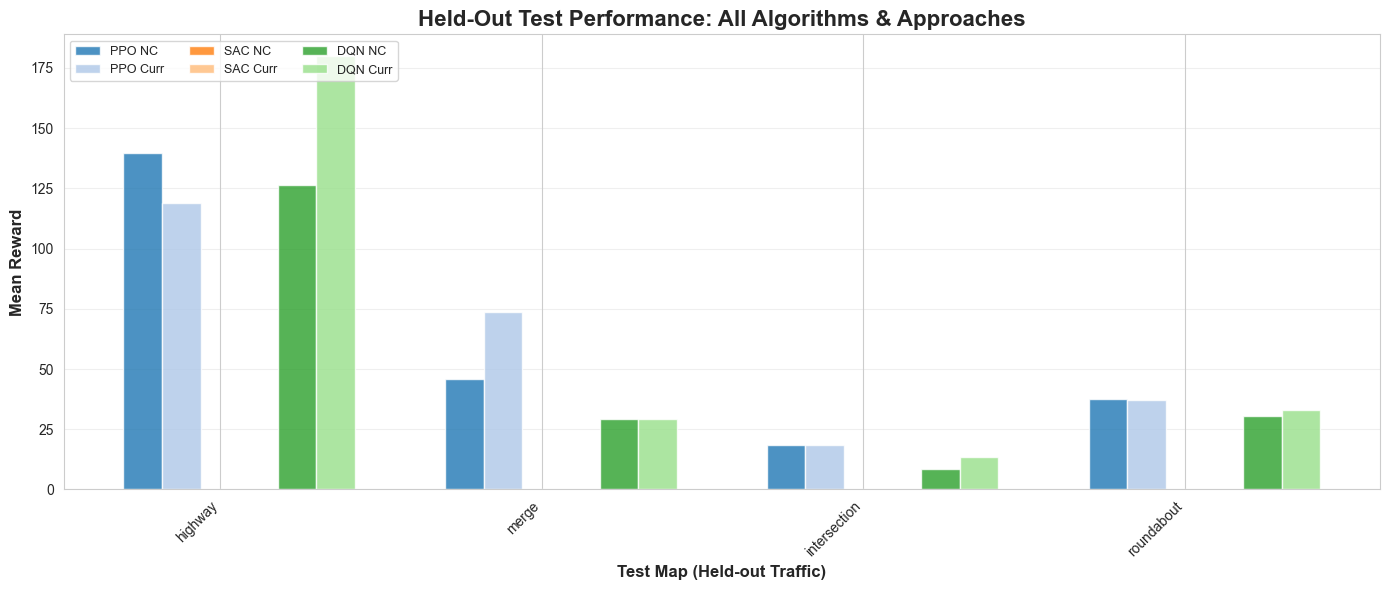

✓ Saved: plots/average_performance.png


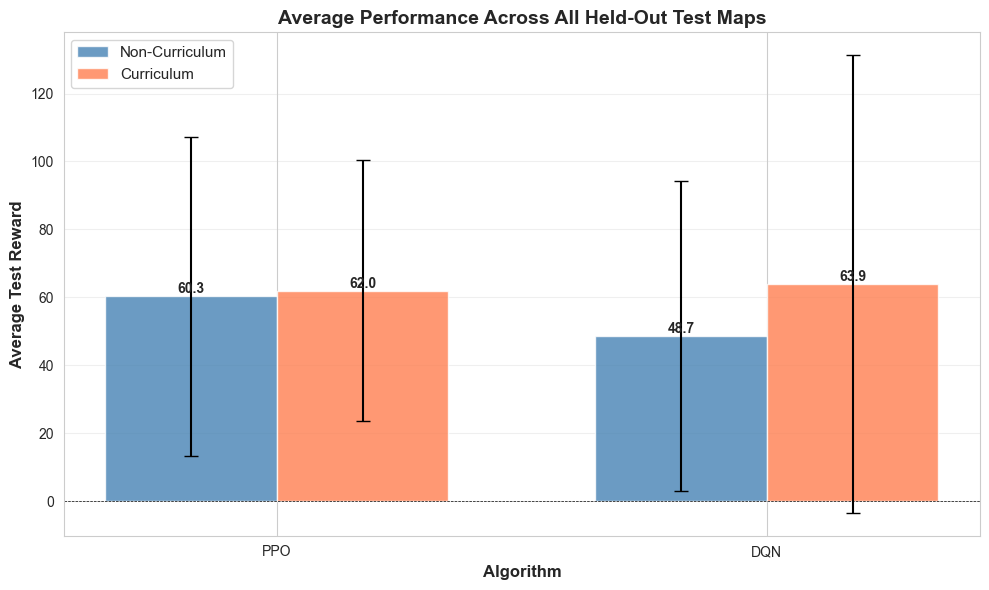

✓ Saved: plots/curriculum_advantage.png


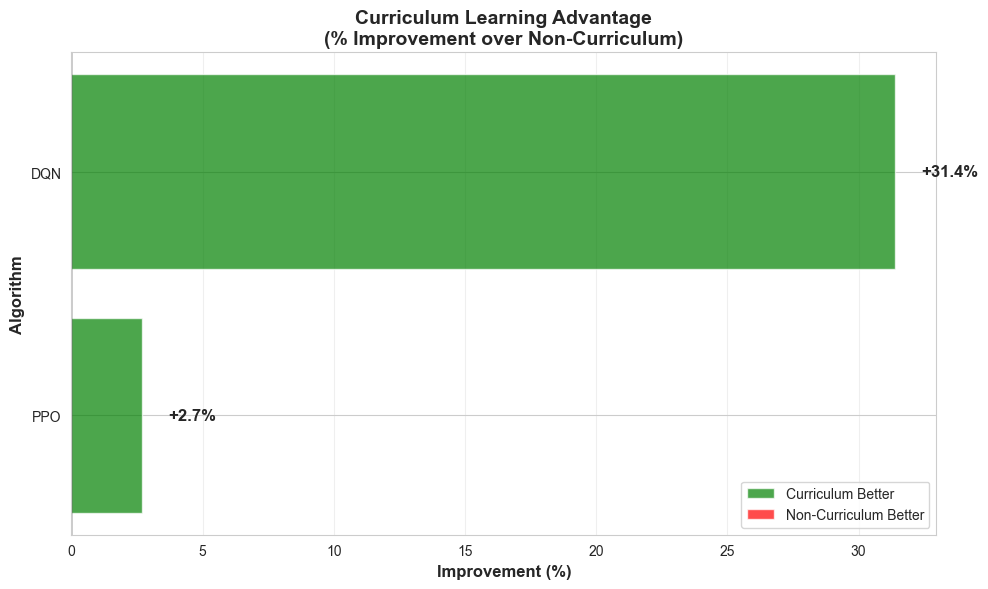

✓ Saved: plots/performance_heatmap.png


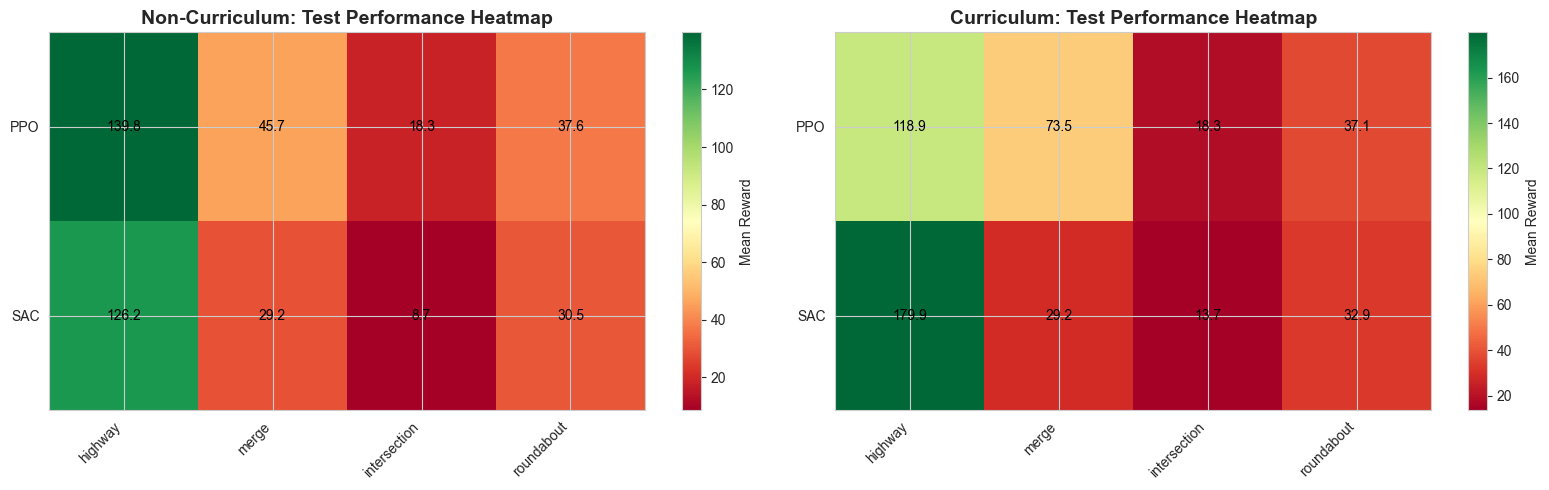


✓ ALL PLOTS GENERATED SUCCESSFULLY!
Saved to: plots/



In [44]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import json
import glob
import os

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

def load_all_results(seed=0):
    """Load all saved experiment results from JSON files"""
    all_data = {}
    algorithms = ['PPO', 'SAC', 'DQN']
    
    for algo in algorithms:
        all_data[algo] = {}
        
        # Load non-curriculum results
        nc_dir = f"experiments/{algo}/noncurriculum/seed_{seed}"
        if os.path.exists(nc_dir):
            run_dirs = glob.glob(os.path.join(nc_dir, "run_*"))
            if run_dirs:
                latest_run = max(run_dirs, key=os.path.getmtime)
                results_file = os.path.join(latest_run, "results_summary.json")
                if os.path.exists(results_file):
                    with open(results_file, 'r') as f:
                        all_data[algo]['non_curriculum'] = json.load(f)
        
        # Load curriculum results
        curr_dir = f"experiments/{algo}/curriculum/seed_{seed}"
        if os.path.exists(curr_dir):
            run_dirs = glob.glob(os.path.join(curr_dir, "run_*"))
            if run_dirs:
                latest_run = max(run_dirs, key=os.path.getmtime)
                results_file = os.path.join(latest_run, "results_summary.json")
                if os.path.exists(results_file):
                    with open(results_file, 'r') as f:
                        all_data[algo]['curriculum'] = json.load(f)
    
    return all_data

def plot_training_performance(all_data, save_path='plots'):
    """Plot 1: Training performance across maps for each algorithm"""
    os.makedirs(save_path, exist_ok=True)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('Training Performance: Non-Curriculum vs Curriculum', fontsize=16, fontweight='bold')
    
    for idx, algo in enumerate(['PPO', 'SAC', 'DQN']):
        ax = axes[idx]
        
        if algo not in all_data or not all_data[algo]:
            ax.text(0.5, 0.5, f'{algo}\nNo data available', 
                   ha='center', va='center', fontsize=12)
            ax.set_title(algo)
            continue
        
        # Extract data
        maps = []
        nc_rewards = []
        curr_rewards = []
        nc_stds = []
        curr_stds = []
        
        if 'non_curriculum' in all_data[algo]:
            nc_data = all_data[algo]['non_curriculum']['training_results']
            for map_name, metrics in nc_data.items():
                if map_name not in maps:
                    maps.append(map_name)
                nc_rewards.append(metrics['mean_reward'])
                nc_stds.append(metrics['std_reward'])
        
        if 'curriculum' in all_data[algo]:
            curr_data = all_data[algo]['curriculum']['stage_results']
            for stage_name, metrics in curr_data.items():
                map_name = metrics['map']
                if map_name in maps:
                    idx_map = maps.index(map_name)
                    if idx_map < len(curr_rewards):
                        continue
                curr_rewards.append(metrics['mean_reward'])
                curr_stds.append(metrics['std_reward'])
        
        # Plot
        x = range(len(maps))
        width = 0.35
        
        if nc_rewards:
            ax.bar([i - width/2 for i in x], nc_rewards, width, 
                  label='Non-Curriculum', alpha=0.8, color='steelblue',
                  yerr=nc_stds, capsize=5)
        if curr_rewards:
            ax.bar([i + width/2 for i in x], curr_rewards, width,
                  label='Curriculum', alpha=0.8, color='coral',
                  yerr=curr_stds, capsize=5)
        
        ax.set_xlabel('Map', fontweight='bold')
        ax.set_ylabel('Mean Reward', fontweight='bold')
        ax.set_title(f'{algo}', fontsize=14, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels([m.replace('-v0', '') for m in maps], rotation=45, ha='right')
        ax.legend()
        ax.grid(axis='y', alpha=0.3)
        ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
    
    plt.tight_layout()
    plt.savefig(f'{save_path}/training_performance.png', dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {save_path}/training_performance.png")
    plt.show()

def plot_holdout_comparison(all_data, save_path='plots'):
    """Plot 2: Held-out test performance comparison"""
    os.makedirs(save_path, exist_ok=True)
    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Prepare data
    results = []
    for algo in ['PPO', 'SAC', 'DQN']:
        if algo not in all_data or not all_data[algo]:
            continue
        
        if 'non_curriculum' in all_data[algo]:
            test_data = all_data[algo]['non_curriculum']['test_results']
            for map_name, metrics in test_data.items():
                results.append({
                    'Algorithm': algo,
                    'Approach': 'Non-Curriculum',
                    'Map': map_name.replace('_holdout', '').replace('-v0', ''),
                    'Mean Reward': metrics['mean_reward'],
                    'Std': metrics['std_reward']
                })
        
        if 'curriculum' in all_data[algo]:
            test_data = all_data[algo]['curriculum']['test_results']
            for map_name, metrics in test_data.items():
                results.append({
                    'Algorithm': algo,
                    'Approach': 'Curriculum',
                    'Map': map_name.replace('_holdout', '').replace('-v0', ''),
                    'Mean Reward': metrics['mean_reward'],
                    'Std': metrics['std_reward']
                })
    
    if not results:
        print("No holdout data available for plotting")
        return
    
    df = pd.DataFrame(results)
    
    # Create grouped bar plot
    maps = df['Map'].unique()
    x = np.arange(len(maps))
    width = 0.12
    
    colors = {'PPO': ['#1f77b4', '#aec7e8'], 
              'SAC': ['#ff7f0e', '#ffbb78'],
              'DQN': ['#2ca02c', '#98df8a']}
    
    for idx, algo in enumerate(['PPO', 'SAC', 'DQN']):
        algo_data = df[df['Algorithm'] == algo]
        
        nc_data = algo_data[algo_data['Approach'] == 'Non-Curriculum']
        curr_data = algo_data[algo_data['Approach'] == 'Curriculum']
        
        nc_rewards = [nc_data[nc_data['Map'] == m]['Mean Reward'].values[0] 
                     if len(nc_data[nc_data['Map'] == m]) > 0 else 0 for m in maps]
        curr_rewards = [curr_data[curr_data['Map'] == m]['Mean Reward'].values[0]
                       if len(curr_data[curr_data['Map'] == m]) > 0 else 0 for m in maps]
        
        offset_nc = (idx * 2 - 2) * width
        offset_curr = (idx * 2 - 1) * width
        
        ax.bar(x + offset_nc, nc_rewards, width, label=f'{algo} NC', 
               color=colors[algo][0], alpha=0.8)
        ax.bar(x + offset_curr, curr_rewards, width, label=f'{algo} Curr',
               color=colors[algo][1], alpha=0.8)
    
    ax.set_xlabel('Test Map (Held-out Traffic)', fontweight='bold', fontsize=12)
    ax.set_ylabel('Mean Reward', fontweight='bold', fontsize=12)
    ax.set_title('Held-Out Test Performance: All Algorithms & Approaches', 
                fontsize=16, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(maps, rotation=45, ha='right')
    ax.legend(ncol=3, loc='upper left', fontsize=9)
    ax.grid(axis='y', alpha=0.3)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
    
    plt.tight_layout()
    plt.savefig(f'{save_path}/holdout_comparison.png', dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {save_path}/holdout_comparison.png")
    plt.show()

def plot_average_performance(all_data, save_path='plots'):
    """Plot 3: Average performance across all test maps"""
    os.makedirs(save_path, exist_ok=True)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    algorithms = []
    nc_avgs = []
    curr_avgs = []
    nc_stds = []
    curr_stds = []
    
    for algo in ['PPO', 'SAC', 'DQN']:
        if algo not in all_data or not all_data[algo]:
            continue
        
        algorithms.append(algo)
        
        if 'non_curriculum' in all_data[algo]:
            test_data = all_data[algo]['non_curriculum']['test_results']
            rewards = [m['mean_reward'] for m in test_data.values()]
            nc_avgs.append(np.mean(rewards))
            nc_stds.append(np.std(rewards))
        else:
            nc_avgs.append(0)
            nc_stds.append(0)
        
        if 'curriculum' in all_data[algo]:
            test_data = all_data[algo]['curriculum']['test_results']
            rewards = [m['mean_reward'] for m in test_data.values()]
            curr_avgs.append(np.mean(rewards))
            curr_stds.append(np.std(rewards))
        else:
            curr_avgs.append(0)
            curr_stds.append(0)
    
    x = np.arange(len(algorithms))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, nc_avgs, width, label='Non-Curriculum',
                   color='steelblue', alpha=0.8, yerr=nc_stds, capsize=5)
    bars2 = ax.bar(x + width/2, curr_avgs, width, label='Curriculum',
                   color='coral', alpha=0.8, yerr=curr_stds, capsize=5)
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.1f}',
                   ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax.set_xlabel('Algorithm', fontweight='bold', fontsize=12)
    ax.set_ylabel('Average Test Reward', fontweight='bold', fontsize=12)
    ax.set_title('Average Performance Across All Held-Out Test Maps', 
                fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(algorithms)
    ax.legend(fontsize=11)
    ax.grid(axis='y', alpha=0.3)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
    
    plt.tight_layout()
    plt.savefig(f'{save_path}/average_performance.png', dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {save_path}/average_performance.png")
    plt.show()

def plot_curriculum_advantage(all_data, save_path='plots'):
    """Plot 4: Curriculum learning advantage (improvement percentage)"""
    os.makedirs(save_path, exist_ok=True)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    algorithms = []
    improvements = []
    colors_list = []
    
    for algo in ['PPO', 'SAC', 'DQN']:
        if algo not in all_data or not all_data[algo]:
            continue
        
        if 'non_curriculum' not in all_data[algo] or 'curriculum' not in all_data[algo]:
            continue
        
        nc_rewards = [m['mean_reward'] for m in all_data[algo]['non_curriculum']['test_results'].values()]
        curr_rewards = [m['mean_reward'] for m in all_data[algo]['curriculum']['test_results'].values()]
        
        nc_avg = np.mean(nc_rewards)
        curr_avg = np.mean(curr_rewards)
        
        if nc_avg != 0:
            improvement = ((curr_avg - nc_avg) / abs(nc_avg)) * 100
        else:
            improvement = 0
        
        algorithms.append(algo)
        improvements.append(improvement)
        colors_list.append('green' if improvement > 0 else 'red')
    
    bars = ax.barh(algorithms, improvements, color=colors_list, alpha=0.7)
    
    # Add value labels
    for i, (bar, imp) in enumerate(zip(bars, improvements)):
        width = bar.get_width()
        label_x = width + (1 if width > 0 else -1)
        ax.text(label_x, bar.get_y() + bar.get_height()/2,
               f'{imp:+.1f}%',
               ha='left' if width > 0 else 'right',
               va='center', fontsize=12, fontweight='bold')
    
    ax.axvline(x=0, color='black', linestyle='-', linewidth=1)
    ax.set_xlabel('Improvement (%)', fontweight='bold', fontsize=12)
    ax.set_ylabel('Algorithm', fontweight='bold', fontsize=12)
    ax.set_title('Curriculum Learning Advantage\n(% Improvement over Non-Curriculum)', 
                fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='green', alpha=0.7, label='Curriculum Better'),
                      Patch(facecolor='red', alpha=0.7, label='Non-Curriculum Better')]
    ax.legend(handles=legend_elements, loc='best')
    
    plt.tight_layout()
    plt.savefig(f'{save_path}/curriculum_advantage.png', dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {save_path}/curriculum_advantage.png")
    plt.show()

def plot_heatmap_comparison(all_data, save_path='plots'):
    """Plot 5: Heatmap of performance across algorithms and maps"""
    os.makedirs(save_path, exist_ok=True)
    
    # Prepare data for non-curriculum
    nc_matrix = []
    curr_matrix = []
    maps = []
    
    for algo in ['PPO', 'SAC', 'DQN']:
        if algo not in all_data or not all_data[algo]:
            continue
        
        if 'non_curriculum' in all_data[algo]:
            test_data = all_data[algo]['non_curriculum']['test_results']
            if not maps:
                maps = [m.replace('_holdout', '').replace('-v0', '') for m in test_data.keys()]
            nc_matrix.append([test_data[list(test_data.keys())[i]]['mean_reward'] 
                             for i in range(len(test_data))])
        
        if 'curriculum' in all_data[algo]:
            test_data = all_data[algo]['curriculum']['test_results']
            curr_matrix.append([test_data[list(test_data.keys())[i]]['mean_reward']
                               for i in range(len(test_data))])
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
    
    # Non-curriculum heatmap
    if nc_matrix:
        im1 = ax1.imshow(nc_matrix, cmap='RdYlGn', aspect='auto')
        ax1.set_xticks(range(len(maps)))
        ax1.set_xticklabels(maps, rotation=45, ha='right')
        ax1.set_yticks(range(len(['PPO', 'SAC', 'DQN'][:len(nc_matrix)])))
        ax1.set_yticklabels(['PPO', 'SAC', 'DQN'][:len(nc_matrix)])
        ax1.set_title('Non-Curriculum: Test Performance Heatmap', 
                     fontsize=14, fontweight='bold')
        
        # Add text annotations
        for i in range(len(nc_matrix)):
            for j in range(len(nc_matrix[0])):
                text = ax1.text(j, i, f'{nc_matrix[i][j]:.1f}',
                              ha="center", va="center", color="black", fontsize=10)
        
        plt.colorbar(im1, ax=ax1, label='Mean Reward')
    
    # Curriculum heatmap
    if curr_matrix:
        im2 = ax2.imshow(curr_matrix, cmap='RdYlGn', aspect='auto')
        ax2.set_xticks(range(len(maps)))
        ax2.set_xticklabels(maps, rotation=45, ha='right')
        ax2.set_yticks(range(len(['PPO', 'SAC', 'DQN'][:len(curr_matrix)])))
        ax2.set_yticklabels(['PPO', 'SAC', 'DQN'][:len(curr_matrix)])
        ax2.set_title('Curriculum: Test Performance Heatmap',
                     fontsize=14, fontweight='bold')
        
        # Add text annotations
        for i in range(len(curr_matrix)):
            for j in range(len(curr_matrix[0])):
                text = ax2.text(j, i, f'{curr_matrix[i][j]:.1f}',
                              ha="center", va="center", color="black", fontsize=10)
        
        plt.colorbar(im2, ax=ax2, label='Mean Reward')
    
    plt.tight_layout()
    plt.savefig(f'{save_path}/performance_heatmap.png', dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {save_path}/performance_heatmap.png")
    plt.show()

def generate_all_plots(seed=0, save_path='plots'):
    """Generate all visualization plots"""
    print("\n" + "="*70)
    print("GENERATING VISUALIZATIONS")
    print("="*70 + "\n")
    
    # Load data
    print("Loading experiment results...")
    all_data = load_all_results(seed)
    
    if not any(all_data.values()):
        print("✗ No experiment data found. Make sure training has completed.")
        return
    
    print(f"✓ Data loaded for: {', '.join([a for a in all_data.keys() if all_data[a]])}\n")
    
    # Generate plots
    print("Generating plots...\n")
    plot_training_performance(all_data, save_path)
    plot_holdout_comparison(all_data, save_path)
    plot_average_performance(all_data, save_path)
    plot_curriculum_advantage(all_data, save_path)
    plot_heatmap_comparison(all_data, save_path)
    
    print(f"\n{'='*70}")
    print(f"✓ ALL PLOTS GENERATED SUCCESSFULLY!")
    print(f"Saved to: {save_path}/")
    print(f"{'='*70}\n")

# Run this after your experiments complete
generate_all_plots(seed=0, save_path='plots')